# Gabrieles Grid [C]

# EMC3 Grid [T]

In [1]:
%matplotlib notebook

import xemc3
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

# loading of data

In [3]:
from pathlib import Path
dsdir = Path("../atomdatpy/NetCDFs-new/")
frad_paths = (sorted(dsdir.glob("N03.00_P05.00_D02_R0*"), reverse=True))[:5]
all_paths = (sorted(dsdir.glob("N03.00_P05.00_D02_R0*"), reverse=True))[:]

In [5]:
bolotype = "QRB"
experiment  = all_paths[0].stem

ds = xr.open_dataset(f"../atomdatpy/NetCDFs-new/{experiment}.nc")
ds_map = xr.open_dataset(f"./{bolotype}-dataset.nc")

# grid dimensions
dim_sizes_C = ds_map.S.shape[1:]
dim_sizes_T = ds.Ez.shape[1:]
dim_names_C = ds_map.S.dims[1:]
dim_names_T = ds.Ez.dims[1:]

# radiated power density in [T] (Ionization, r, theta, phi)
ez_T = ds.Ez

# Sensitivity / geometry matrix in [C] (foil, p, z, r)
gm_C = ds_map.S

# [C] -> [T] mapping (*[C], sample, [T]coord)
# map_C_T[*coord_in_C][sample] == [r, theta, phi]
map_C_T = ds_map.Map # keep as floats so nans stay
map_C_T_int = ds_map.Map.astype(int)

In [6]:
ds_map

<xarray.Dataset>
Dimensions:  (foil: 88, p: 10, z: 85, r: 47, hit: 2, xyz: 3, sample: 20, xemc3_vars: 3, dp: 2, dz: 2, dr: 2)
Coordinates:
    x_vert   (p, z, r, dp, dz, dr) float64 ...
    y_vert   (p, z, r, dp, dz, dr) float64 ...
    z_vert   (p, z, r, dp, dz, dr) float64 ...
    phi      (p) float64 ...
Dimensions without coordinates: foil, p, z, r, hit, xyz, sample, xemc3_vars, dp, dz, dr
Data variables:
    S        (foil, p, z, r) float64 ...
    V        (p, z, r) float64 ...
    Etendue  (foil) float64 ...
    los      (foil, hit, xyz) float64 ...
    Vlos     (foil) float64 ...
    dlos     (foil) float64 ...
    id       (foil) object ...
    Map      (p, z, r, sample, xemc3_vars) float64 ...
Attributes:
    environment:  QRB
    description:  x,y,z_vert [m] = voxel vertices \nphi [deg] = slice toroida...

# map inversion

we want to map the geometry matrix from gabrieles cylindrical grid (C) on to my xemc3 toriodal (T) grid (both may change) to apply it to the Emissivity values to calculate the sightline foil power absorption values from.

The mapping (M) takes the cell indices (l,m,n) of the cylindrical grid cell as well as an extra index (q in [0,Q]) defining the position inside the cell, and maps that to the indices (i,j,k) of the toroidal grid cell
As the geometry marix values (g) are extensive values, we can sum them together for the fusion of two cells.
So as we subsample the cylindrical grid cells into Q subcells, each of these has geometry matrix value $g_{\text{subcell}} = g_{\text{cell}}/Q$.
Then we can add the subcell-g's for all C-subcells that lie in the T-cell together to get $g^T_{i,j,k}$:

$$
M: [0,\hat{l}] \times [0,\hat{m}] \times [0,\hat{n}] \times [0,Q] 
\to [0,\hat{i}] \times [0,\hat{j}] \times [0,\hat{k}], \quad (l,m,n,q) \mapsto (M_i(l,m,n,q),~M_k(l,m,n,q),~M_j(l,m,n,q))\\
\delta_{(i,j,k),~ M(l,m,n,q)} := \delta_{i,~ M_i(l,m,n,q)} \cdot \delta_{j,~ M_j(l,m,n,q)} \cdot \delta_{k,~ M_k(l,m,n,q)} \quad \text{Which describes if }l,m,n,q\text{ maps to }i,j,k\text{.}$$


$$ \Large
g^T_{i,j,k} = 
 \sum_{l,m,n,q} \frac{g^C_{l,m,n}}{Q} \cdot \delta_{(i,j,k),~ M(l,m,n,q)}$$
 
We could try to improve the accuracy of the mapped geometry matrix by taking into account the Volume of the C-subcells that lie in the new cell vs the volume of the T-cell, but this breaks dramatically when the volume of the T-cells gets much smaller than the C-subcell volumes, because then instead of one C-cell with $g_1$ mapping to n-1 T-cells with $g=0$ and one with $g=g_1$, it would map the one to $g=g_1/Q$ which drastically reduces the geometry matrix sum.

In [7]:
# flatten the mapping to remove all [C]->[T] maps to nan (cells in [C] that get mapped outside of [T])
# this is done by flattening the domain and image of the mapping
flat_map_domain = np.array(np.meshgrid(map_C_T.p, map_C_T.z, map_C_T.r, map_C_T.sample,
                                       indexing="ij")).transpose(1,2,3,4,0).reshape(-1,4)
flat_map_image = map_C_T.values.reshape(-1,3)

# now we can remove the nans (and convert the mapping array to int, as non nan indices are now all integers)
not_nan_indices = ~np.isnan(flat_map_image[:,0])  

flat_map_domain = flat_map_domain[not_nan_indices]
flat_map_image = flat_map_image[not_nan_indices].astype(int)

# print length reference
percent_ref = len(flat_map_domain) // 100

In [8]:
# now define a function that takes an input array I in [T] coordinates 
# and an output array Q in [C] coordinates
# and loops over the mapping, applying I[image] to Q[domain]
def mapf_T_C(input_T, output_C, prezeroed=False):
    if not prezeroed: output_C[...] = 0
    for i , (domain_coord, image_coord) in enumerate(zip(flat_map_domain[...,:-1], flat_map_image)):
        if not i % percent_ref:
            print(i//percent_ref, end=", ")
        output_C[(..., *domain_coord)] += np.nan_to_num(input_T[(..., *image_coord)])
        
# for good measure the other way around, too
# taking care here that the [C] array has samples for the mapping that are
# not relevant in the data storage
def mapf_C_T(input_C, output_T, prezeroed=False):
    if not prezeroed: output_T[...] = 0
    # remove sample from coord
    for i, (domain_coord, image_coord) in enumerate(zip(flat_map_domain[...,:-1], flat_map_image)):
        if not i % percent_ref:
            print(i//percent_ref, end=", ")
        output_T[(..., *image_coord)] += np.nan_to_num(input_C[(..., *domain_coord)])

# for both mappings extra data needs to be encoded into leading dimensions / axes
# BOTH EXTREMELY SLOW

In [9]:
# assumes the input is preshaped into 2d array, with 2d as the values not to be touched
def fast_mapf_C_T(input_C, output_T):
    input_C = input_C[not_nan_indices]
    
    i = 0
    for input_val, image_coord in zip(input_C, flat_map_image):
        if not i % percent_ref:
            print(i//percent_ref, end=", ")
        output_T[tuple(image_coord)] += input_val
        i += 1

# works with nice arrays, but also with extrans at end
def fast_mapf_T_C(input_T, output_C):
    i = 0
    for p in map_C_T.p:
        for z in map_C_T.z:
            for r in map_C_T.r:
                for sample in map_C_T.sample:
                    T_coord = map_C_T[p,z,r,sample]
                    if not np.isnan(T_coord[0]):
                        output_C[p,z,r] += np.nan_to_num(input_T[tuple(map_C_T_int[p,z,r,sample])])
                        if not i % percent_ref:
                            print(i//percent_ref, end=", ")
                        i += 1

# gm_C -> gm_T

In [10]:
preproc_gm_C = gm_C.expand_dims(sample=ds_map.sample)\
                   .transpose("p", "z", "r", "sample", "foil")\
                   .values.reshape(-1, gm_C.foil.size)

raw_gm_T = np.zeros((*dim_sizes_T, gm_C.shape[0]))

In [11]:
fast_mapf_C_T(preproc_gm_C, raw_gm_T)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 

In [12]:
gm_T = xr.DataArray(data = raw_gm_T.transpose(3,0,1,2),
                    dims = (gm_C.dims[0], *dim_names_T))

# each cell in [C] has 20 samples which which we map to [T] 
# and then sum those together.
# but effectively only a 1/sample.size of the [C] cell maps to [T] which is why we need to divide by this here
# equivalent reason for ez
gm_T /= ds_map.sample.size

In [13]:
ds_map["S"].sum(dim=("foil", "z", "r"))

<xarray.DataArray 'S' (p: 10)>
array([1.53150449e-09, 1.43997241e-08, 4.05663374e-08, 7.20288319e-08,
       6.70287729e-08, 8.35152447e-08, 5.26005351e-08, 3.33355809e-08,
       1.77099987e-08, 5.77799330e-09])
Coordinates:
    phi      (p) float64 197.5 198.5 199.5 200.5 ... 203.5 204.5 205.5 206.5
Dimensions without coordinates: p

In [14]:
gm_T.to_netcdf(f"./tempdata/geometry_matrix_T_{bolotype}_{experiment}.nc")

<IPython.core.display.Javascript object>


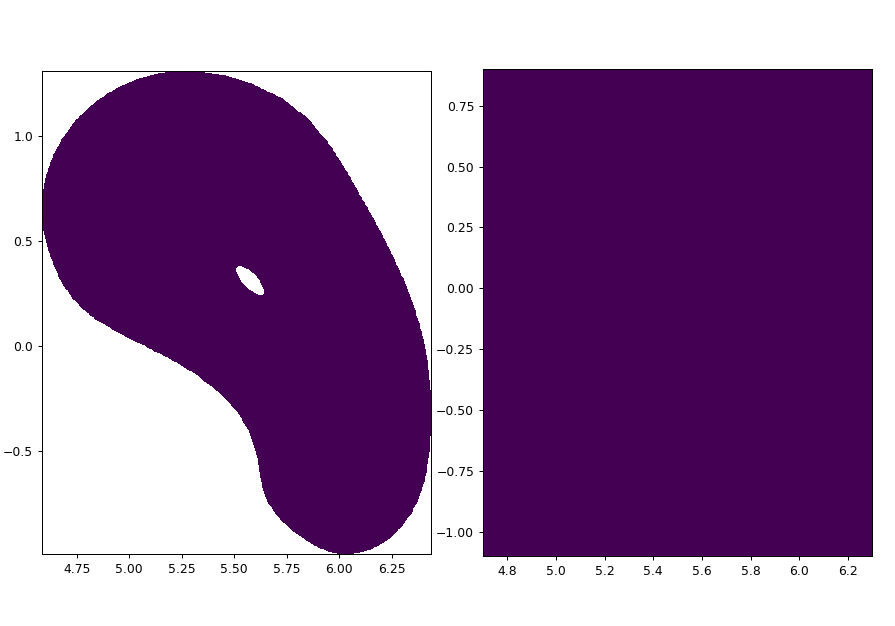

interactive(children=(FloatSlider(value=3.5255650890285453, description='phi', max=3.612831551628262, min=3.43…

In [20]:
import mapping_geometry_data_evaluation as mgde
mgde.combination_plot_gm(ds_map, ds, gm_T, phi=0.5, foil_index=48,
                 sf = lambda x: np.log(x+1e-10), scale_by_volume=True)

# ez_T -> ez_C

In [21]:
ez_C = xr.DataArray(data = np.zeros((ez_T.shape[0], *dim_sizes_C)),
                    dims = (ez_T.dims[0], *dim_names_C))

mapf_T_C(ez_T, ez_C)

# each cell in [C] has 20 samples which which we map backwards from [T] and then sum those together.
# luckily Ez is a density quantity, which means we do not need to care how many [C] cells point to a [T] cell, because they do not
# share the E_z, but __all__ have it for a 1/sample.size of theyr cell themselves
# -> averaging E_z -> == summing and dividing
ez_C /= ds_map.sample.size

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 

preproc_ez_T = ez_T.transpose("r", "theta", "phi", "Ionization")
raw_ez_C = np.zeros((*dim_sizes_C, ez_T.shape[0]))

In [22]:
ez_C.to_netcdf(f"./tempdata/emissivity_C_{bolotype}_{experiment}.nc")

<IPython.core.display.Javascript object>


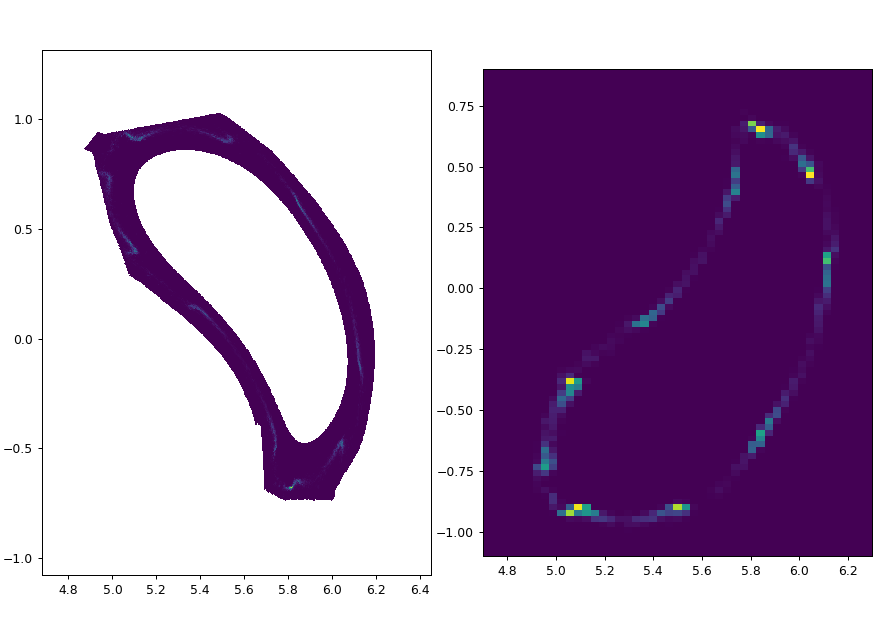

interactive(children=(FloatSlider(value=3.5255650890285453, description='phi', max=3.612831551628262, min=3.43…

In [23]:
mgde.combination_plot_ez(ds_map, ds, ez_C, phi=1.85, Ionization_index=3,
                         sf = lambda x: x, scale_by_volume=False)

In [24]:
# save data before everything dies
np.savez(f"./tempdata/[C] [T] mapped data {bolotype}_{experiment}", ez_C=ez_C, ez_T=ez_T, gm_C=gm_C, gm_T=gm_T)

In [25]:
np.all(ez_C == 0)

<xarray.DataArray ()>
array(False)

# absorbed power in [C]

In [26]:
Power_C = (ez_C * gm_C).transpose("Ionization", "foil", "p", "z", "r")

# absorbed power in [T]

In [27]:
Power_T = (ez_T * gm_T).transpose("Ionization", "foil", "r", "theta", "phi")

# comparing data

In [28]:
plot_power_C = Power_C.sum(dim=("Ionization", "p", "z", "r"))
plot_power_T = Power_T.sum(dim=("Ionization", "r", "theta", "phi"))

<IPython.core.display.Javascript object>


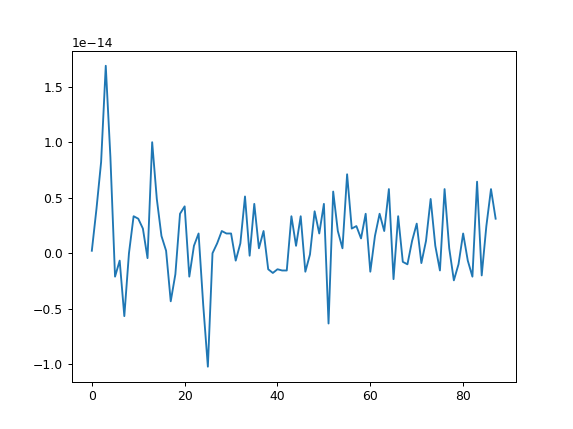

In [32]:
plt.close("all")
plt.plot(plot_power_C/plot_power_T - 1)

<IPython.core.display.Javascript object>


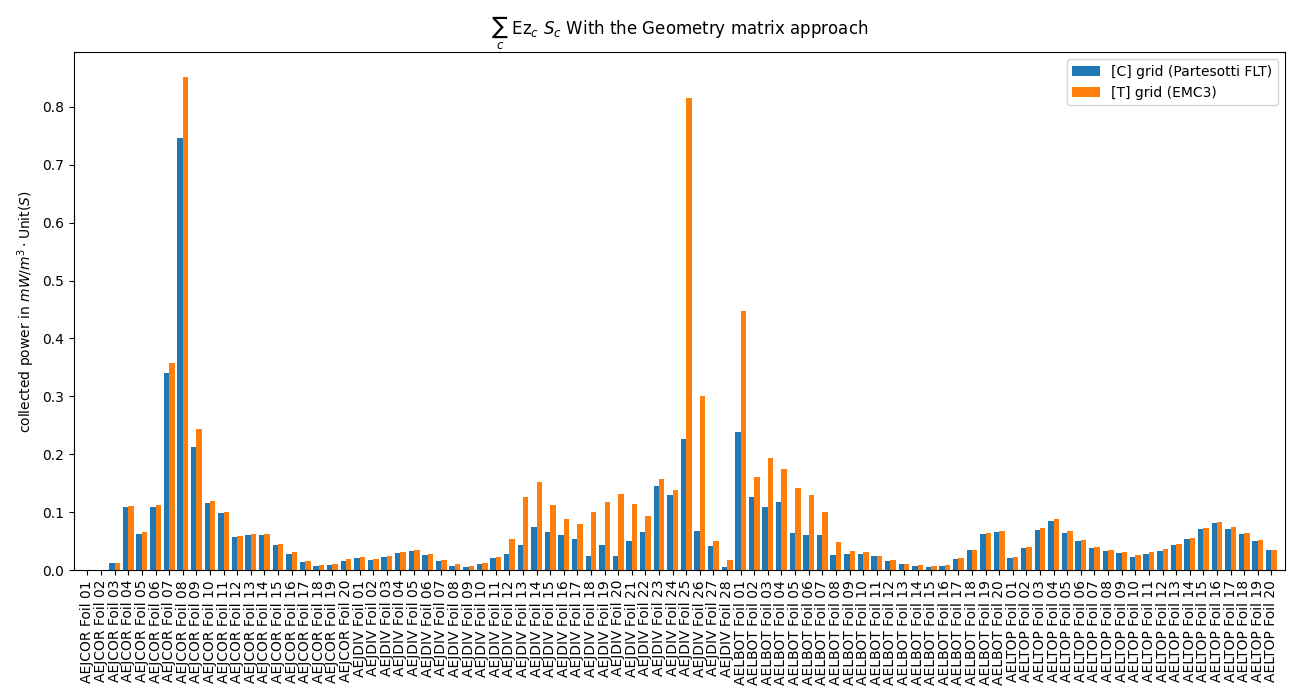

Ellipsis

In [48]:
fig, ax = plt.subplots(figsize=(13,7))
tmp_x = np.arange(len(Power_C.foil))

mW_factor = 1000

labels = []
for l_str in ds_map.id:
    l_str = l_str.data[()]
    front = " ".join(l_str.split(" ")[:-1])
    back = f"{int(l_str.split(' ')[-1]):02d}"
    labels.append(front+" "+back)

ax.bar(tmp_x-0.2, mW_factor*plot_power_C, width=0.4, label=f"[C] grid (Partesotti FLT)")
ax.bar(tmp_x+0.2, mW_factor*plot_power_T, width=0.4, label=f"[T] grid (EMC3)")

ax.set_xticks(tmp_x)
ax.set_xticklabels(labels, rotation=90)
ax.set_xlim(-1, len(tmp_x))
ax.set_title("$\sum_c ~\mathrm{Ez}_c ~S_c$ With the Geometry matrix approach")
ax.set_ylabel("collected power in $mW/m^3 \cdot \mathrm{Unit}(S)$")
ax.legend()
fig.tight_layout()
...

In [30]:
Power_T.size / (2**30)

1.4698333740234375